Reference: Vekuri, H., Tuovinen, JP., Kulmala, L. et al. A widely-used eddy covariance gap-filling method creates systematic bias in carbon balance estimates. Sci Rep 13, 1720 (2023). https://doi.org/10.1038/s41598-023-28827-2
code availbility: https://github.com/hvekuri/co2_gapfilling

In [ ]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
site_data_dir = Path('/content/drive/MyDrive/synthetic_data/')
# List all files in the directory
file_list = [file for file in site_data_dir.iterdir() if file.is_file()]

# Print the list of files
for file in file_list:
    print(file.name)
def add_time_vars(data):
  data['DOY_sin'] = np.sin((data['Day']-1)*(2*np.pi/12))
  data['DOY_cos'] = np.cos((data['Day']-1)*(2*np.pi/12))
  data['Month_sin'] = np.sin((data['Month']-1)*(2*np.pi/12))
  data['Month_cos'] = np.cos((data['Month']-1)*(2*np.pi/12))
  data['Hour_sin'] = np.sin(data['Hour']*(2*np.pi/24))
  data['Hour_cos'] = np.cos(data['Hour']*(2*np.pi/24))
  data.replace({-9999: np.nan}, inplace=True)
  return data

x_cols = ['TIMESTAMP_END','evi', 'gcc', 'SWC_1_f', 'SWC_4_f', 'Tair_f', 'Tsoil', 'VPD_f', 'PPFD_DIF', 'PPFD_DIR', 'PPFD_f', 'DOY_sin', 'DOY_cos', 'SW_IN_F']
y_col = 'NEE_U50_orig'

site_data = pd.read_csv(site_data_dir / "site_data.csv", index_col=0) # .dropna(subset=[y_col])
site_data = site_data[site_data['Year'] > 2009]
site_data = add_time_vars(site_data)
site_data["SW_IN_F"] = site_data['Rg']
site_data["NEE"] = site_data['NEE_U50_orig']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
site_data.csv
sythetic_data_ANN.csv
ANN_site_data.csv


<ipython-input-36-cbff4cacccb6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DOY_sin'] = np.sin((data['Day']-1)*(2*np.pi/12))
<ipython-input-36-cbff4cacccb6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DOY_cos'] = np.cos((data['Day']-1)*(2*np.pi/12))
<ipython-input-36-cbff4cacccb6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [ ]:
# Define the x_cols
x_cols = ['Tair_f', 'Tsoil', 'VPD_f', 'SW_IN_F']

# Check for NaNs in the four variables
nan_check = site_data[x_cols].isnull().sum()
print(nan_check)

Tair_f     0
Tsoil      0
VPD_f      0
SW_IN_F    0
dtype: int64


In [ ]:
# the codes are adapted fllowing Vekur et al. 2023
random.seed(10)
def generate_model(in_d):
    """
    Model
    """
    model = Sequential()
    model.add(Dense(16, activation='linear',
                    input_dim=in_d))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(
        Dense(1, activation="linear"))
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

def add_residuals(synth_data):
    """
    Adds noise to synthetic NEE based on temperature
    """
    synth_data['residual'] = (synth_data.NEE-synth_data.modelled_NEE).values
    assignments, edges = pd.qcut(
        synth_data['Tair_f'], 5, retbins=True, labels=False)
    synth_data['label'] = assignments

    for label in synth_data.label.unique():
        cur = synth_data[(synth_data.label == label) & (
            synth_data.residual.notnull())]
        if len(cur) < 20:
            cur = synth_data[(synth_data.label <= label+1) & (
            synth_data.residual.notnull())]
            if len(cur) < 20:
                cur = synth_data[(synth_data.label <= label+2) & (
                synth_data.residual.notnull())]
                if len(cur) < 20:
                    cur = synth_data[(synth_data.label <= label+3) & (
                synth_data.residual.notnull())]

        res = cur.residual.sample(
            len(synth_data[(synth_data.label == label)]), replace=True).values

        synth_data.loc[(synth_data.label == label),
                           'synth_NEE'] = synth_data.loc[(synth_data.label == label), 'modelled_NEE'] + res

    #new = synth_data[['synth_NEE', 'Tair_f', 'Tsoil', 'SW_IN_F', 'VPD_f']].copy()
    new = synth_data[['synth_NEE', 'Tair_f', 'Tsoil', 'SW_IN_F', 'VPD_f', 'gcc']].copy()
    # new.columns = ['NEE', 'Tair_f', 'Tsoil', 'SW_IN_F','VPD_f']
    new.columns = ['NEE', 'Tair_f', 'Tsoil', 'SW_IN_F','VPD_f','gcc']
    return new

def make_synth_data(data, x_cols, y_col):
    """
    Makes a synthetic data set using neural network
    """
    all_train_data = data[(data.NEE.notnull())] # This is important
    X = np.asarray(all_train_data[x_cols])
    y = np.asarray(all_train_data[y_col])
    X, y = shuffle(X, y)
    scaler_x = StandardScaler().fit(X)
    X = scaler_x.transform(X)
    scaler_y = StandardScaler().fit(y.reshape(-1, 1))
    y = scaler_y.transform(y.reshape(-1, 1))

    X_all = scaler_x.transform(np.asarray(data[x_cols]))

    model = generate_model(len(x_cols))
    history = model.fit(X, y, epochs=200, batch_size=32)

    pred_all_y = model.predict(X_all)
    pred_all_y = scaler_y.inverse_transform(pred_all_y)

    data['modelled_NEE'] = pred_all_y # then add noice to data

    # Filter data for winter and summer months based on the 'Month' column
    winter = data[data['Month'].isin([1, 2, 3, 4, 11, 12])].copy()
    summer = data[data['Month'].isin([5, 6, 7, 8, 9, 10])].copy()

    synth_data1 = add_residuals(winter[winter.SW_IN_F < 20].copy())
    synth_data2 = add_residuals(winter[winter.SW_IN_F >= 20].copy())
    synth_data3 = add_residuals(summer[summer.SW_IN_F < 20].copy())
    synth_data4 = add_residuals(summer[summer.SW_IN_F >= 20].copy())
    synth_data = pd.concat([synth_data1, synth_data2, synth_data3, synth_data4])
    synth_data = synth_data.sort_index()

    #return synth_data
    return data

Epoch 1/200
2358/2358 [==============================] - 6s 2ms/step - loss: 0.3049
Epoch 2/200
2358/2358 [==============================] - 5s 2ms/step - loss: 0.2409
Epoch 3/200
2358/2358 [==============================] - 5s 2ms/step - loss: 0.2273
Epoch 4/200
2358/2358 [==============================] - 5s 2ms/step - loss: 0.2221
Epoch 5/200
2358/2358 [==============================] - 6s 3ms/step - loss: 0.2198
Epoch 6/200
2358/2358 [==============================] - 5s 2ms/step - loss: 0.2184
Epoch 7/200
2358/2358 [==============================] - 8s 3ms/step - loss: 0.2166
Epoch 8/200
2358/2358 [==============================] - 5s 2ms/step - loss: 0.2140
Epoch 9/200
2358/2358 [==============================] - 7s 3ms/step - loss: 0.2118
Epoch 10/200
2358/2358 [==============================] - 7s 3ms/step - loss: 0.2121
Epoch 11/200
2358/2358 [==============================] - 5s 2ms/step - loss: 0.2105
Epoch 12/200
2358/2358 [==============================] - 6s 3ms/step - lo

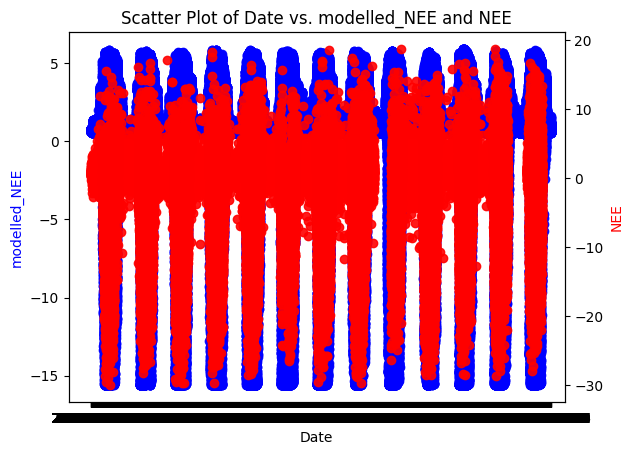

In [ ]:
x_cols = ['Tair_f', 'Tsoil', 'VPD_f', 'SW_IN_F']
x_cols = ['Tair_f', 'Tsoil', 'VPD_f', 'SW_IN_F', 'gcc', 'SWC_1_f', 'SWC_4_f']
make_synth_data(site_data, x_cols, y_col)

import matplotlib.pyplot as plt
# Create a figure and axis object
fig, ax1 = plt.subplots()

# Plot site_data["modelled_NEE"] on the primary y-axis with transparent blue color
ax1.scatter(site_data["Date"], site_data["modelled_NEE"], color='b', alpha=0.9)
ax1.set_xlabel("Date")
ax1.set_ylabel("modelled_NEE", color='b')

# Create a secondary y-axis and plot site_data["NEE"] on it with transparent red color
ax2 = ax1.twinx()
ax2.scatter(site_data["Date"], site_data["NEE"], color='r', alpha=0.9)
ax2.set_ylabel("NEE", color='r')

# Add title
plt.title("Scatter Plot of Date vs. modelled_NEE and NEE")

# Show the plot
plt.show()

In [ ]:
import os
print(site_data_dir)
# Define the file path for saving
csv_file_path = os.path.join(site_data_dir, "ANN_site_data.csv")
# Save site_data to a CSV file
site_data.to_csv(csv_file_path, index=False)

/content/drive/MyDrive/synthetic_data
